In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import csv
from scipy.optimize import *
from numpy.lib.recfunctions import *
from utils import *
from data import *

In [3]:
# Print data columns
x.dtype.names

('classification',
 'distance_to_port',
 'distance_to_shore',
 'measure_course_diff',
 'measure_courseavg_10800',
 'measure_courseavg_1800',
 'measure_courseavg_21600',
 'measure_courseavg_3600',
 'measure_courseavg_43200',
 'measure_courseavg_86400',
 'measure_coursestddev_10800',
 'measure_coursestddev_1800',
 'measure_coursestddev_21600',
 'measure_coursestddev_3600',
 'measure_coursestddev_43200',
 'measure_coursestddev_86400',
 'measure_distance_to_port',
 'measure_heading_diff',
 'measure_new_score_10800',
 'measure_new_score_1800',
 'measure_new_score_21600',
 'measure_new_score_3600',
 'measure_new_score_43200',
 'measure_new_score_86400',
 'measure_pos_10800',
 'measure_pos_1800',
 'measure_pos_21600',
 'measure_pos_3600',
 'measure_pos_43200',
 'measure_pos_86400',
 'measure_speed',
 'measure_speed_diff',
 'measure_speedavg_10800',
 'measure_speedavg_1800',
 'measure_speedavg_21600',
 'measure_speedavg_3600',
 'measure_speedavg_43200',
 'measure_speedavg_86400',
 'measure_spe

In [4]:
windows = [int(name[len("measure_courseavg_"):]) for name in x.dtype.names if name.startswith("measure_courseavg_")]
windows.sort()
print windows

[1800, 3600, 10800, 21600, 43200, 86400]


In [5]:
for window in windows:
    x = append_fields(x, 'measure_speedstddev_%s_log' % window, [], dtypes='<f8', fill_value=0.0)
    x['measure_speedstddev_%s_log' % window] = log10(x['measure_speedstddev_%s' % window]+0.001)

    x = append_fields(x, 'measure_coursestddev_%s_log' % window, [], dtypes='<f8', fill_value=0.0)
    x['measure_coursestddev_%s_log' % window] = log10(x['measure_coursestddev_%s' % window]+0.001)


In [18]:
cols = ["speed"]
for window in windows:
    cols += ['measure_speedavg_%s' % window,
             'measure_speedstddev_%s_log' % window,
             'measure_coursestddev_%s_log' % window]
cols = [x[col] for col in cols]
    
score_args = curve_fit(mpolynomial, cols, x['classification'], [1]*(len(cols)*4))[0]

print score_args

[  1.22494629e+05  -1.50094862e-03  -2.19866391e-04   1.96406011e-06
  -1.15893622e+05  -2.46993800e+00   5.09184992e+00  -2.93332788e+00
   1.22494629e+05   3.15396796e-01   1.68373636e-01   3.03675507e-02
   1.22494629e+05   1.37619129e-01   1.02236318e-01   1.78182153e-02
  -1.75045435e+04  -1.05081836e+00   1.80995274e+00  -9.20344399e-01
   1.22494629e+05  -1.60426843e-01  -7.67484593e-02  -1.09730374e-02
   1.22494629e+05   3.66612815e-02   2.11597841e-02   2.05890155e-03
   2.09016703e+04  -3.72194342e+00   6.17924746e+00  -3.15104563e+00
   1.22494629e+05  -5.40404991e-02  -1.96644815e-02   1.72542545e-03
   1.22494629e+05  -1.01072844e-01  -9.26315166e-02  -2.28987495e-02
  -3.21226974e+04  -3.32763736e+00   4.53119474e+00  -2.07589220e+00
   1.22494629e+05  -9.12294109e-02  -1.05375604e-01  -2.30947744e-02
   1.22494629e+05  -3.74750885e-01  -3.33155013e-01  -7.14124110e-02
  -1.37088425e+04   3.51014796e+00  -3.84530269e+00   1.27079785e+00
  -1.43410078e+06  -1.15299138e+00

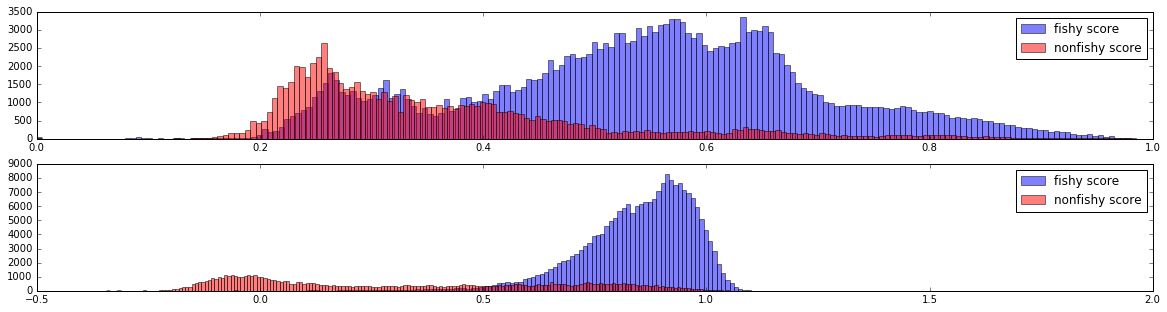

In [19]:
try:
    x = append_fields(x, 'score', [], dtypes='<f8', fill_value=0.0)
except:
    pass

x['score'][:] = mpolynomial(cols, *score_args)

xfishy = fishy(x)
xnonfishy = nonfishy(x)


histfig = figure(figsize=(20,5))

subplot = histfig.add_subplot(211)
new_score_fishy = subplot.hist(xfishy["measure_new_score_3600"][xfishy['distance_to_shore'] > 3], bins=200, normed=False, color='b', alpha=0.5, label="fishy score")
new_score_nonfishy = subplot.hist(xnonfishy["measure_new_score_3600"][xnonfishy['distance_to_shore'] > 3], bins=200, normed=False, color='r', alpha=0.5, label="nonfishy score")
legend()

subplot = histfig.add_subplot(212)
score_fishy = subplot.hist(xfishy["score"][xfishy['distance_to_shore'] > 3], bins=200, normed=False, color='b', alpha=0.5, label="fishy score")
score_nonfishy = subplot.hist(xnonfishy["score"][xnonfishy['distance_to_shore'] > 3], bins=200, normed=False, color='r', alpha=0.5, label="nonfishy score")
legend()


show()


In [20]:
total = sum(new_score_fishy[0] + new_score_nonfishy[0])
non_overlap = sum(abs(new_score_fishy[0] - new_score_nonfishy[0]))
overlap = total - non_overlap
error = overlap / total

print "Error for measure_new_score: %s%%" % (error * 100)


total = sum(score_fishy[0] + score_nonfishy[0])
non_overlap = sum(abs(score_fishy[0] - score_nonfishy[0]))
overlap = total - non_overlap
error = overlap / total

print "Error for score: %s%%" % (error * 100)

Error for measure_new_score: 42.1728959889%
Error for score: 18.4058125795%
